In [119]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import stop_words
import string
from nltk.corpus import wordnet
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder


In [2]:
df_se = pd.read_csv('./data/softeng1000.csv').drop('Unnamed: 0', axis=1)
df_sp = pd.read_csv('./data/sports1000.csv').drop('Unnamed: 0', axis=1)

In [3]:
df_se['category'] = 'softeng'
df_sp['category'] = 'sport'

In [4]:
df_all = pd.concat([df_se, df_sp]).reset_index(drop=True)
df_all.loc[[0,1,1998,1999]]

,title,pageid,length,content,category
0,acceptance testing,3233,16735,"In engineering and its various subdisciplines,...",softeng
1,computer programming,5311,21691,Computer programming (often shortened to progr...,softeng
1998,1766 to 1770 in sports,55653852,5397,Events in world sport through the years 1766 t...,sport
1999,sports before 1001,55657864,13727,This article presents a chronology of sporting...,sport


# NLP

## Pre-Processing

In [5]:
lemmatizer = WordNetLemmatizer()

In [6]:
def get_wordnet_tag(treebank_tag):
    """ enables to map pos tags from treebank to wordnet valid pos tags 
    (in order to feed the lemmatizer) """
    
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:  # if starts with N or others (noun by default)
        return wordnet.NOUN
    
def lemmatize(token):
    """ final method to lemmatize using wordnet lemmatizer """
    
    trbk_tag = pos_tag([token])[0][1]  # get the treebank tag from pos_tag method
    wrdnt_tag = get_wordnet_tag(treebank_tag=trbk_tag)  # translate it to wordnet tag
    return lemmatizer.lemmatize(token, wrdnt_tag)

stop_words_ = stop_words.get_stop_words("en")
punctuation_filter = str.maketrans({key: None for key in string.punctuation})

def nlp_pre_process(text):
    """
    Reduces an input text into a list of tokens, 
    using NLP filterings such as normalization, 
    PoS and stop word filtering, stemming.
    text: (str)
    tokens: list(str)
    """
    text = text.lower()  # normalize
    text = text.translate(punctuation_filter)  # remove punctuation
    tokens = word_tokenize(text)  # tokenize
    pos_tags = [pos_tag([t]) for t in tokens]  # PoS tagging
    tokens = [token for [(token, tag)] in pos_tags if tag != "DT"]  # PoS filtering
    tokens = [t for t in tokens if t not in stop_words_]  # stop words filtering

    tokens = [lemmatize(t) for t in tokens]  # lemmatizing
    
    return " ".join(tokens)

In [7]:
from tqdm import tqdm, tqdm_notebook
tqdm.pandas(tqdm_notebook())

df_all.content = df_all.content.progress_apply(nlp_pre_process)

100%|██████████| 2000/2000 [09:56<00:00,  6.65it/s]


In [11]:
df_all.to_csv("./wikiArticles_preprocessed.csv")

## TF-IDF

In [188]:
df = pd.read_csv("./data/wikiArticles_preprocessed.csv", index_col='title').drop(['Unnamed: 0','length','pageid'], axis=1)

In [189]:
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(df.category)
df.category = label_encoder.transform(df.category) #softeng -> 0, sports -> 1

In [190]:
df.head()

,content,category
title,,
acceptance testing,engineering various subdisciplines acceptance ...,0
computer programming,computer program often shorten program process...,0
computer program,computer program collection instruction perfor...,0
context-free grammar,formal language theory contextfree grammar cfg...,0
code coverage,computer science code coverage measure use des...,0


In [210]:
Xtrain = pd.concat([df[0:900], df[1000:1900]]).drop('category',axis=1)
Xtest = pd.concat([df[900:1000], df[1900:2000]]).drop('category',axis=1)

ytrain = pd.concat([df[0:900], df[1000:1900]]).drop('content',axis=1)
ytest = pd.concat([df[900:1000], df[1900:2000]]).drop('content',axis=1)

In [197]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()

In [198]:
Xtrain_counts = count_vect.fit_transform(Xtrain.content)

In [199]:
print('sparse matrix shape: ' + str(Xtrain_counts.shape))
print('non zero count: ' + str(Xtrain_counts.nnz))
print('sparcity: ' + str(100*Xtrain_counts.nnz / (Xtrain_counts.shape[0] * Xtrain_counts.shape[1])))

sparse matrix shape: (1800, 62057)
non zero count: 502567
sparcity: 0.4499152213108737


In [200]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()

In [201]:
Xtrain_tfidf = tfidf_transformer.fit_transform(Xtrain_counts)

In [202]:
Xtrain_tfidf.shape

(1800, 62057)

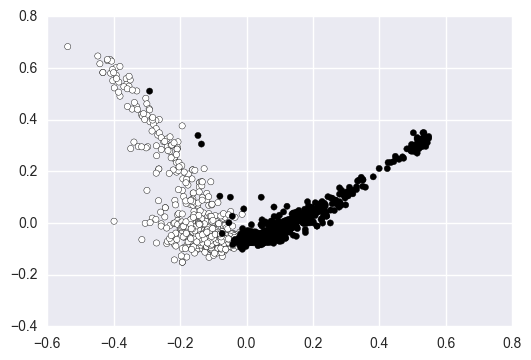

In [203]:
Xtrain_tfidf_dense = Xtrain_tfidf.todense()
pca = PCA(n_components=2).fit(Xtrain_tfidf_dense)
data2D = pca.transform(Xtrain_tfidf_dense)
plt.scatter(data2D[:,0], data2D[:,1], c=ytrain.category)

In [206]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix,classification_report

In [208]:
pipeline = Pipeline([
    ('bow', CountVectorizer()),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [214]:
pipeline.fit(Xtrain.content,ytrain.category)

Pipeline(steps=[('bow', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_...f=False, use_idf=True)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [215]:
predictions = pipeline.predict(Xtest.content)

In [216]:
print(confusion_matrix(ytest.category,predictions))
print(classification_report(ytest.category,predictions))

[[ 97   3]
 [  0 100]]
             precision    recall  f1-score   support

          0       1.00      0.97      0.98       100
          1       0.97      1.00      0.99       100

avg / total       0.99      0.98      0.98       200

